# Projeto de Mineração de Dados

>### Segmentação de Clientes em Shopping Centers

**Dataset**: *Mall Customers*

*Por Renzzo, V.* (2025)

### Instalar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings

warnings.filterwarnings("ignore")

### Configurações de visualização

In [2]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

#### 1. CARREGAMENTO E DESCRIÇÃO DA BASE DE DADOS

In [3]:
df = pd.read_csv("data/Mall_Customers.csv")

In [4]:
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

####  2. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [7]:
round(df.describe(), 3)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000,200.000,200.000,200.000
mean,100.500,38.850,60.560,50.200
std,57.879,13.969,26.265,25.824
min,1.000,18.000,15.000,1.000
25%,50.750,28.750,41.500,34.750
50%,100.500,36.000,61.500,50.000
75%,150.250,49.000,78.000,73.000
max,200.000,70.000,137.000,99.000


In [8]:
df["Gender"].value_counts()

Gender
Female    112
Male       88
Name: count, dtype: int64

In [9]:
print(f"\nPercentual Masculino: {(df['Gender'] == 'Male').sum() / len(df) * 100:.1f}%")


Percentual Masculino: 44.0%


In [10]:
print(f"Percentual Feminino: {(df['Gender'] == 'Female').sum() / len(df) * 100:.1f}%")

Percentual Feminino: 56.0%


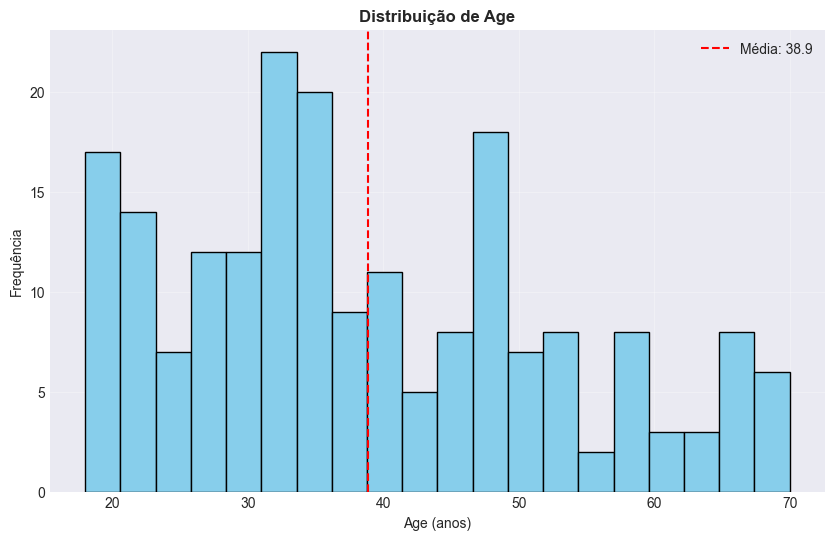

In [11]:
# Visualização da Distribuição de Idade
plt.figure(figsize=(10, 6))
plt.hist(df["Age"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuição de Age", fontsize=12, fontweight="bold")
plt.xlabel("Age (anos)")
plt.ylabel("Frequência")
plt.axvline(
    df["Age"].mean(),
    color="red",
    linestyle="--",
    label=f'Média: {df["Age"].mean():.1f}',
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

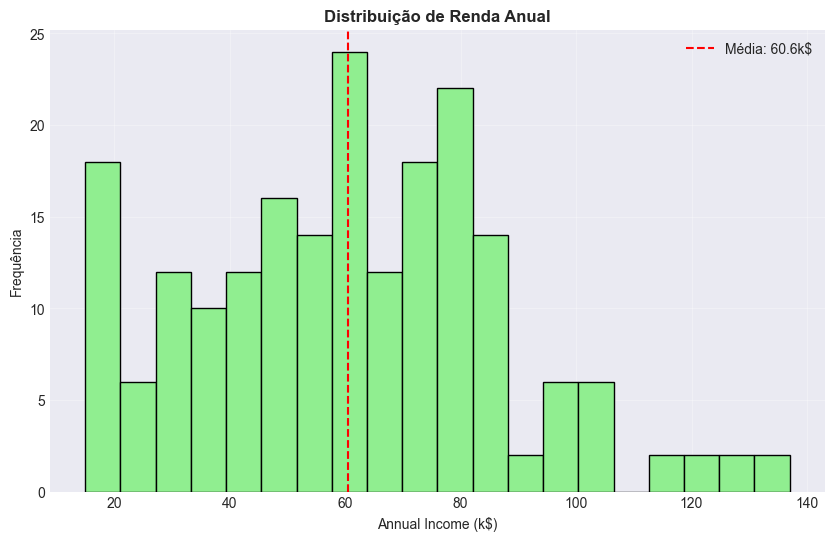

In [12]:
# Visualização da Distribuição de Renda
plt.figure(figsize=(10, 6))
plt.hist(df["Annual Income (k$)"], bins=20, color="lightgreen", edgecolor="black")
plt.title("Distribuição de Renda Anual", fontsize=12, fontweight="bold")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Frequência")
plt.axvline(
    df["Annual Income (k$)"].mean(),
    color="red",
    linestyle="--",
    label=f'Média: {df["Annual Income (k$)"].mean():.1f}k$',
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

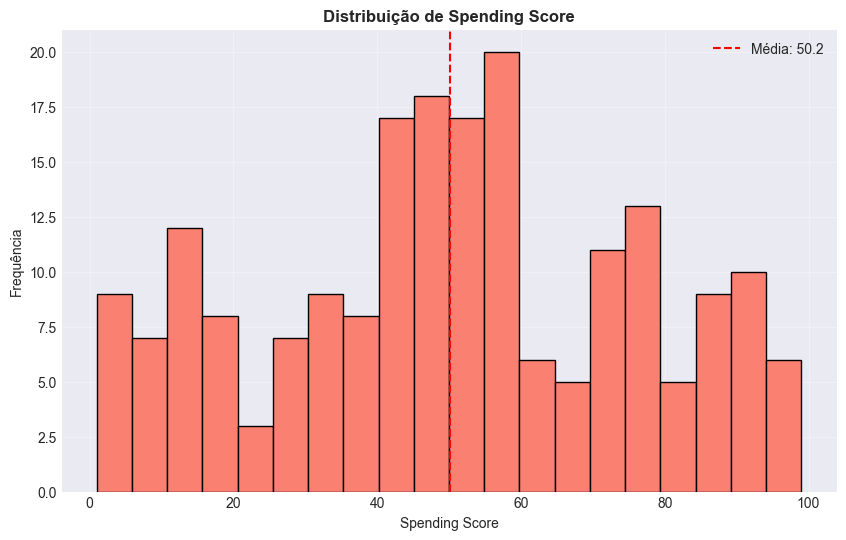

In [13]:
# Visualização da Distribuição de Spending Score
plt.figure(figsize=(10, 6))
plt.hist(df["Spending Score (1-100)"], bins=20, color="salmon", edgecolor="black")
plt.title("Distribuição de Spending Score", fontsize=12, fontweight="bold")
plt.xlabel("Spending Score")
plt.ylabel("Frequência")
plt.axvline(
    df["Spending Score (1-100)"].mean(),
    color="red",
    linestyle="--",
    label=f'Média: {df["Spending Score (1-100)"].mean():.1f}',
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

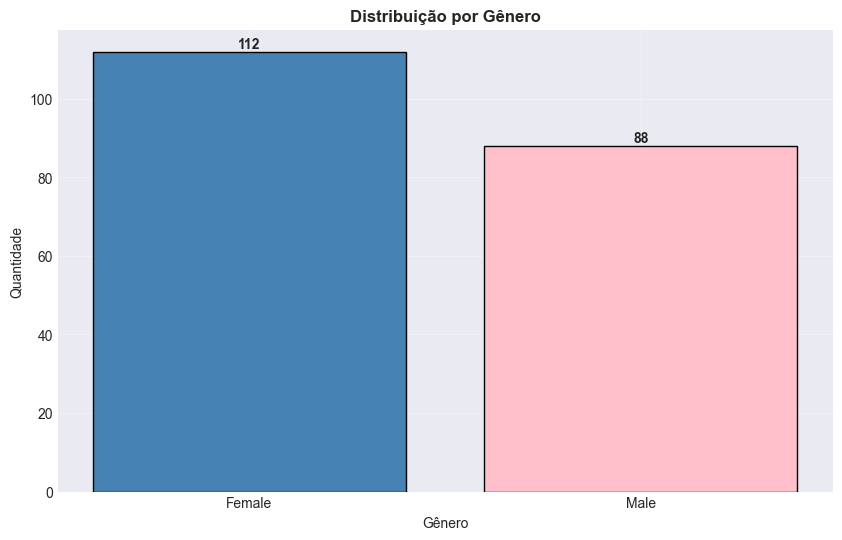

In [14]:
# Visualização da Distribuição por Gênero
plt.figure(figsize=(10, 6))
gender_counts = df["Gender"].value_counts()
plt.bar(
    gender_counts.index,
    gender_counts.values,
    color=["steelblue", "pink"],
    edgecolor="black",
)
plt.title("Distribuição por Gênero", fontsize=12, fontweight="bold")
plt.xlabel("Gênero")
plt.ylabel("Quantidade")
plt.grid(True, alpha=0.3)

# Adicionar valores sobre as barras
for i, v in enumerate(gender_counts.values):
    plt.text(i, v + 1, str(v), ha="center", fontweight="bold")

plt.show()

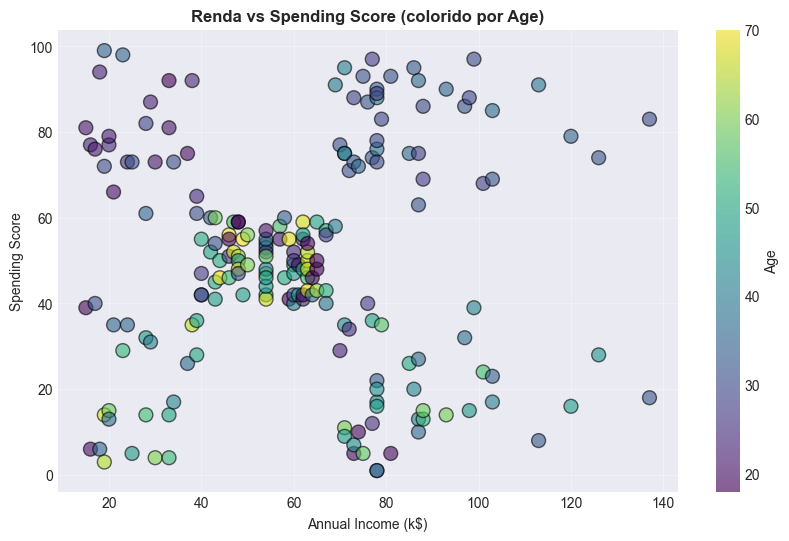

In [15]:
# Visualização da Relação entre Renda e Spending Score
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["Annual Income (k$)"],
    df["Spending Score (1-100)"],
    c=df["Age"],
    cmap="viridis",
    alpha=0.6,
    s=100,
    edgecolors="black",
)
plt.title("Renda vs Spending Score (colorido por Age)", fontsize=12, fontweight="bold")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.colorbar(scatter, label="Age")
plt.grid(True, alpha=0.3)
plt.show()

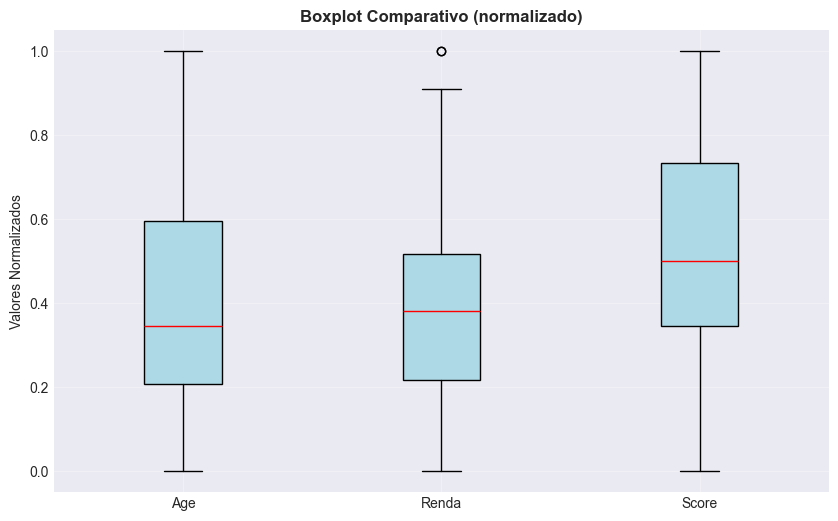

In [16]:
# Visualização do Boxplot Comparativo
plt.figure(figsize=(10, 6))

# Normalizar os dados
df_melted = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
df_melted.columns = ["Age (norm)", "Renda (norm)", "Score (norm)"]

# Criar boxplot
plt.boxplot(
    [df_melted["Age (norm)"], df_melted["Renda (norm)"], df_melted["Score (norm)"]],
    labels=["Age", "Renda", "Score"],
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(color="black", markeredgecolor="black"),
)

plt.title("Boxplot Comparativo (normalizado)", fontsize=12, fontweight="bold")
plt.ylabel("Valores Normalizados")
plt.grid(True, alpha=0.3)
plt.show()


Matriz de Correlação:
                             Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000


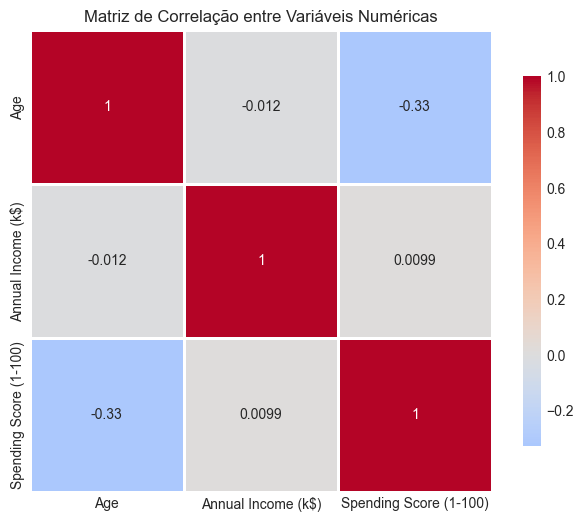

In [17]:
# Matriz de correlação
print("\nMatriz de Correlação:")
correlation_matrix = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].corr()
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

#### 3. PRÉ-PROCESSAMENTO DOS DADOS

In [18]:
# Criar cópia do dataframe para processamento
df_processed = df.copy()

##### 3.1 Codificação de variáveis categóricas

In [19]:
le = LabelEncoder()
df_processed["Gender_Encoded"] = le.fit_transform(df_processed["Gender"])
print(
    f"Gender codificado: Male = {le.transform(['Male'])[0]}, Female = {le.transform(['Female'])[0]}"
)

Gender codificado: Male = 1, Female = 0


##### 3.2 Normalização Min-Max

In [20]:
scaler = MinMaxScaler()
features_to_normalize = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
df_processed[["Idade_Norm", "Renda_Norm", "Score_Norm"]] = scaler.fit_transform(
    df_processed[features_to_normalize]
)

print("\nAmostra de dados normalizados:")
df_processed[["Age", "Idade_Norm", "Annual Income (k$)", "Renda_Norm"]].head()


Amostra de dados normalizados:


,Age,Idade_Norm,Annual Income (k$),Renda_Norm
0,19,0.019231,15,0.000000
1,21,0.057692,15,0.000000
2,20,0.038462,16,0.008197
3,23,0.096154,16,0.008197
4,31,0.250000,17,0.016393


##### 3.3 Discretização para Apriori

In [21]:
def discretizar_idade(idade):
    if idade < 30:
        return "Jovem"
    elif idade < 50:
        return "Adulto"
    else:
        return "Senior"


def discretizar_renda(renda):
    if renda < 50:
        return "Renda_Baixa"
    elif renda < 90:
        return "Renda_Media"
    else:
        return "Renda_Alta"


def discretizar_score(score):
    if score < 35:
        return "Score_Baixo"
    elif score < 70:
        return "Score_Medio"
    else:
        return "Score_Alto"


df_processed["Idade_Group"] = df_processed["Age"].apply(discretizar_idade)
df_processed["Renda_Group"] = df_processed["Annual Income (k$)"].apply(
    discretizar_renda
)
df_processed["Score_Group"] = df_processed["Spending Score (1-100)"].apply(
    discretizar_score
)

In [22]:
print("\nDistribuição das faixas etárias:")
df_processed["Idade_Group"].value_counts()


Distribuição das faixas etárias:


Idade_Group
Adulto    100
Jovem      55
Senior     45
Name: count, dtype: int64

In [23]:
print("\nDistribuição das faixas de renda:")
df_processed["Renda_Group"].value_counts()


Distribuição das faixas de renda:


Renda_Group
Renda_Media    106
Renda_Baixa     72
Renda_Alta      22
Name: count, dtype: int64

In [24]:
print("\nDistribuição das faixas de score:")
df_processed["Score_Group"].value_counts()


Distribuição das faixas de score:


Score_Group
Score_Medio    96
Score_Alto     54
Score_Baixo    50
Name: count, dtype: int64

In [25]:
# Amostra de dados processados:

df_processed[
    [
        "CustomerID",
        "Gender",
        "Idade_Group",
        "Renda_Group",
        "Score_Group",
        "Idade_Norm",
        "Renda_Norm",
    ]
].head(10)


,CustomerID,Gender,Idade_Group,Renda_Group,Score_Group,Idade_Norm,Renda_Norm
0,1,Male,Jovem,Renda_Baixa,Score_Medio,0.019231,0.000000
1,2,Male,Jovem,Renda_Baixa,Score_Alto,0.057692,0.000000
2,3,Female,Jovem,Renda_Baixa,Score_Baixo,0.038462,0.008197
3,4,Female,Jovem,Renda_Baixa,Score_Alto,0.096154,0.008197
4,5,Female,Adulto,Renda_Baixa,Score_Medio,0.250000,0.016393
5,6,Female,Jovem,Renda_Baixa,Score_Alto,0.076923,0.016393
6,7,Female,Adulto,Renda_Baixa,Score_Baixo,0.326923,0.024590
7,8,Female,Jovem,Renda_Baixa,Score_Alto,0.096154,0.024590
8,9,Male,Senior,Renda_Baixa,Score_Baixo,0.884615,0.032787
9,10,Female,Adulto,Renda_Baixa,Score_Alto,0.230769,0.032787


#### 4. AGRUPAMENTO DE DADOS - K-MEANS

In [26]:
# Preparar dados para clustering (usar variáveis normalizadas)
X_clustering = df_processed[["Renda_Norm", "Score_Norm"]].values


4.1 Determinação do Número Ótimo de Clusters - Método do Cotovelo


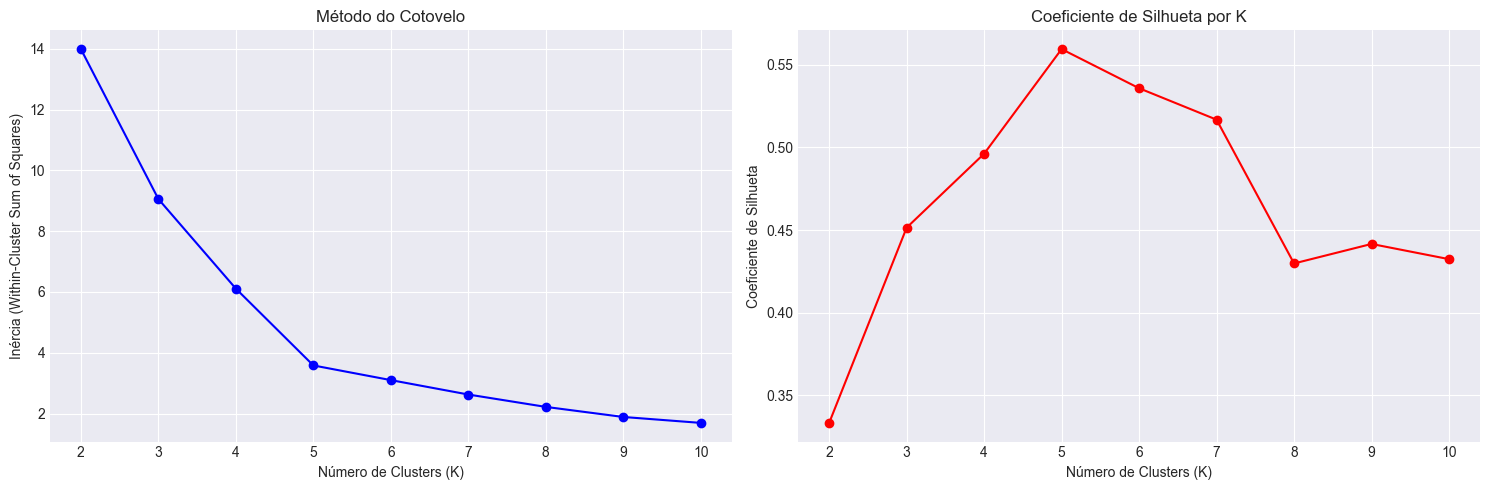

In [27]:
# 4.1 Método do Cotovelo (Elbow Method)
print("\n4.1 Determinação do Número Ótimo de Clusters - Método do Cotovelo")
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering, kmeans.labels_))
    
# Visualizar Método do Cotovelo e Silhueta
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, "bo-")
axes[0].set_xlabel("Número de Clusters (K)")
axes[0].set_ylabel("Inércia (Within-Cluster Sum of Squares)")
axes[0].set_title("Método do Cotovelo")
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, "ro-")
axes[1].set_xlabel("Número de Clusters (K)")
axes[1].set_ylabel("Coeficiente de Silhueta")
axes[1].set_title("Coeficiente de Silhueta por K")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Escolher K ótimo baseado na silhueta
k_otimo = K_range[np.argmax(silhouette_scores)]
k_otimo

5

In [29]:
# 4.2 Executar K-means com K ótimo
print(f"\n4.2 Executando K-means com K = {k_otimo}")
kmeans_final = KMeans(n_clusters=k_otimo, random_state=42, n_init=10)
df_processed["Cluster_KMeans"] = kmeans_final.fit_predict(X_clustering)


4.2 Executando K-means com K = 5


In [30]:
# 4.3 Métricas de Avaliação
print("\n4.3 Métricas de Avaliação do Clustering")
silhueta = silhouette_score(X_clustering, df_processed["Cluster_KMeans"])
davies_bouldin = davies_bouldin_score(X_clustering, df_processed["Cluster_KMeans"])

print(f"Inércia: {kmeans_final.inertia_:.4f}")
print(f"Coeficiente de Silhueta: {silhueta:.4f}")
print(f"Índice Davies-Bouldin: {davies_bouldin:.4f}")
print("\nInterpretação:")
print("- Silhueta próximo de 1: ótima separação dos clusters")
print("- Davies-Bouldin menor: melhor separação")


4.3 Métricas de Avaliação do Clustering
Inércia: 3.5831
Coeficiente de Silhueta: 0.5595
Índice Davies-Bouldin: 0.5678

Interpretação:
- Silhueta próximo de 1: ótima separação dos clusters
- Davies-Bouldin menor: melhor separação


In [31]:
# 4.4 Distribuição dos clusters
print("\n4.4 Distribuição dos Clientes por Cluster")
cluster_dist = df_processed["Cluster_KMeans"].value_counts().sort_index()
cluster_dist


4.4 Distribuição dos Clientes por Cluster


Cluster_KMeans
0    22
1    35
2    39
3    81
4    23
Name: count, dtype: int64

In [32]:
# 4.5 Perfil dos Clusters
print("\n4.5 Perfil Detalhado dos Clusters")
for cluster_id in sorted(df_processed["Cluster_KMeans"].unique()):
    cluster_data = df_processed[df_processed["Cluster_KMeans"] == cluster_id]
    print(f"\n{'='*60}")
    print(
        f"CLUSTER {cluster_id} - {len(cluster_data)} clientes ({len(cluster_data)/len(df)*100:.1f}%)"
    )
    print(f"{'='*60}")
    print(f"Idade média: {cluster_data['Age'].mean():.1f} anos")
    print(f"Renda média: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
    print(f"Spending Score médio: {cluster_data['Spending Score (1-100)'].mean():.1f}")
    print(
        f"% Masculino: {(cluster_data['Gender'] == 'Male').sum() / len(cluster_data) * 100:.1f}%"
    )
    print(
        f"% Feminino: {(cluster_data['Gender'] == 'Female').sum() / len(cluster_data) * 100:.1f}%"
    )

    # Caracterização do cluster
    avg_income = cluster_data["Annual Income (k$)"].mean()
    avg_score = cluster_data["Spending Score (1-100)"].mean()

    if avg_income < 50 and avg_score < 40:
        perfil = "Econômicos - Baixa renda e baixo gasto"
    elif avg_income > 70 and avg_score > 60:
        perfil = "Premium - Alta renda e alto gasto"
    elif avg_income < 50 and avg_score > 60:
        perfil = "Entusiastas - Baixa renda mas alto gasto"
    elif avg_income > 70 and avg_score < 40:
        perfil = "Conservadores - Alta renda mas baixo gasto"
    else:
        perfil = "Moderados - Renda e gasto médios"

    print(f"\nPerfil: {perfil}")


4.5 Perfil Detalhado dos Clusters

CLUSTER 0 - 22 clientes (11.0%)
Idade média: 25.3 anos
Renda média: $25.7k
Spending Score médio: 79.4
% Masculino: 40.9%
% Feminino: 59.1%

Perfil: Entusiastas - Baixa renda mas alto gasto

CLUSTER 1 - 35 clientes (17.5%)
Idade média: 41.1 anos
Renda média: $88.2k
Spending Score médio: 17.1
% Masculino: 54.3%
% Feminino: 45.7%

Perfil: Conservadores - Alta renda mas baixo gasto

CLUSTER 2 - 39 clientes (19.5%)
Idade média: 32.7 anos
Renda média: $86.5k
Spending Score médio: 82.1
% Masculino: 46.2%
% Feminino: 53.8%

Perfil: Premium - Alta renda e alto gasto

CLUSTER 3 - 81 clientes (40.5%)
Idade média: 42.7 anos
Renda média: $55.3k
Spending Score médio: 49.5
% Masculino: 40.7%
% Feminino: 59.3%

Perfil: Moderados - Renda e gasto médios

CLUSTER 4 - 23 clientes (11.5%)
Idade média: 45.2 anos
Renda média: $26.3k
Spending Score médio: 20.9
% Masculino: 39.1%
% Feminino: 60.9%

Perfil: Econômicos - Baixa renda e baixo gasto


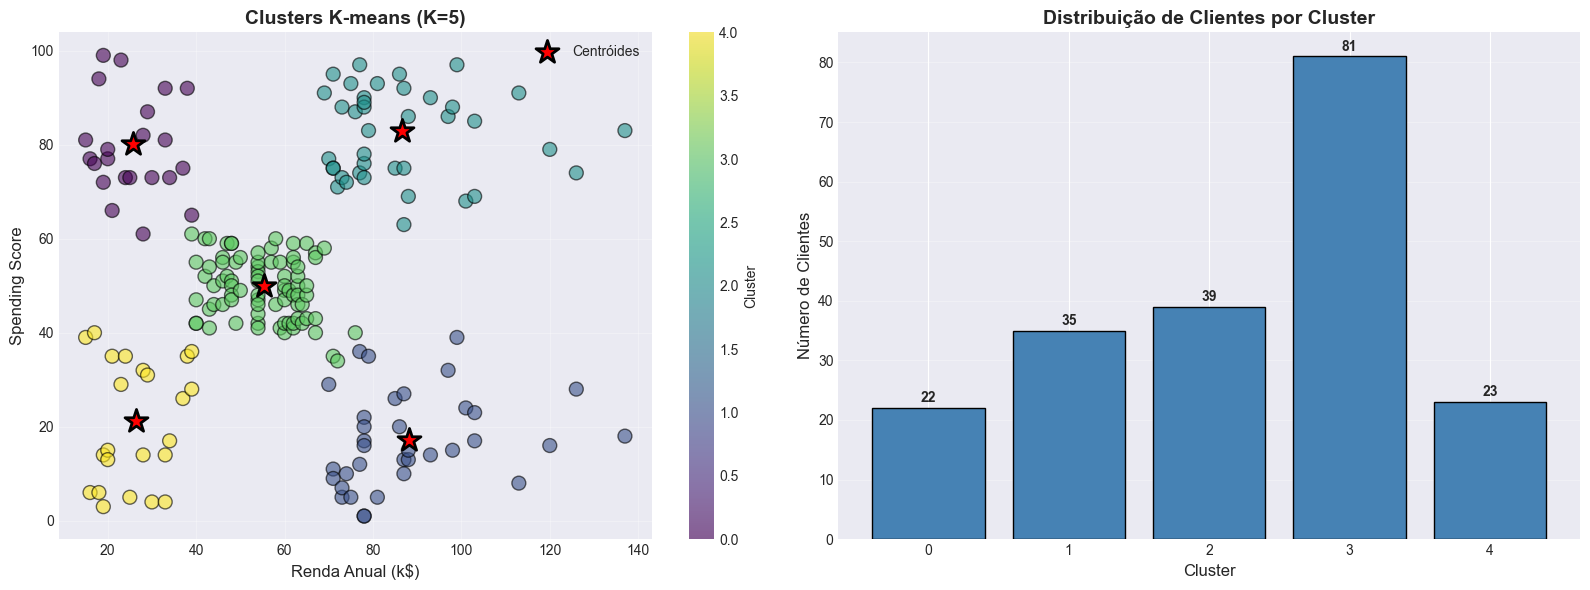

In [33]:
# Visualização dos Clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot dos clusters
scatter = axes[0].scatter(
    df_processed["Annual Income (k$)"],
    df_processed["Spending Score (1-100)"],
    c=df_processed["Cluster_KMeans"],
    cmap="viridis",
    s=100,
    alpha=0.6,
    edgecolors="black",
)
axes[0].scatter(
    kmeans_final.cluster_centers_[:, 0] * 122 + 15,  # desnormalizar
    kmeans_final.cluster_centers_[:, 1] * 99 + 1,
    c="red",
    s=300,
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Centróides",
)
axes[0].set_xlabel("Renda Anual (k$)", fontsize=12)
axes[0].set_ylabel("Spending Score", fontsize=12)
axes[0].set_title(f"Clusters K-means (K={k_otimo})", fontsize=14, fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label="Cluster")

# Distribuição por cluster
cluster_counts = df_processed["Cluster_KMeans"].value_counts().sort_index()
axes[1].bar(
    cluster_counts.index, cluster_counts.values, color="steelblue", edgecolor="black"
)
axes[1].set_xlabel("Cluster", fontsize=12)
axes[1].set_ylabel("Número de Clientes", fontsize=12)
axes[1].set_title(
    "Distribuição de Clientes por Cluster", fontsize=14, fontweight="bold"
)
axes[1].grid(True, axis="y", alpha=0.3)

for i, v in enumerate(cluster_counts.values):
    axes[1].text(i, v + 1, str(v), ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

#### 5. CLUSTERING HIERÁRQUICO (COMPARAÇÃO)

In [34]:
# Executar clustering hierárquico
hierarchical = AgglomerativeClustering(n_clusters=k_otimo, linkage="ward")
df_processed["Cluster_Hierarchical"] = hierarchical.fit_predict(X_clustering)

print(f"\nClustering Hierárquico com K = {k_otimo} (método Ward)")
print("\nDistribuição dos Clusters:")
df_processed["Cluster_Hierarchical"].value_counts().sort_index()


Clustering Hierárquico com K = 5 (método Ward)

Distribuição dos Clusters:


Cluster_Hierarchical
0    39
1    86
2    32
3    20
4    23
Name: count, dtype: int64

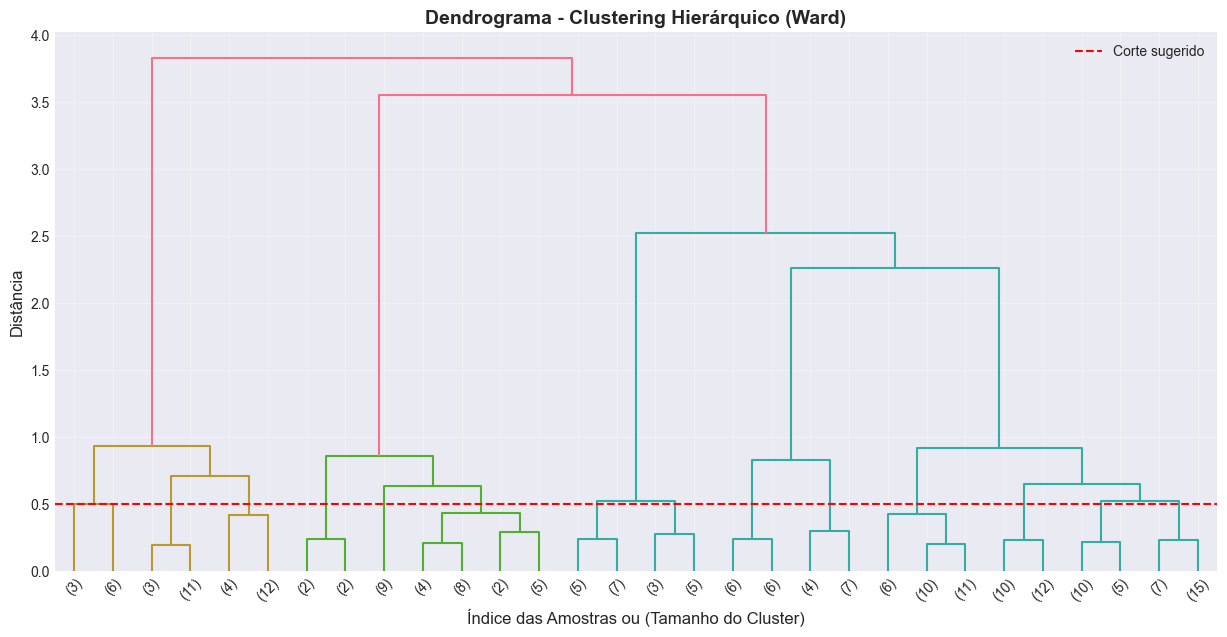

In [35]:
# Dendrograma
plt.figure(figsize=(15, 7))
linkage_matrix = linkage(X_clustering, method="ward")
dendrogram(linkage_matrix, truncate_mode="lastp", p=30, leaf_font_size=10)
plt.title("Dendrograma - Clustering Hierárquico (Ward)", fontsize=14, fontweight="bold")
plt.xlabel("Índice das Amostras ou (Tamanho do Cluster)", fontsize=12)
plt.ylabel("Distância", fontsize=12)
plt.axhline(y=0.5, color="r", linestyle="--", label="Corte sugerido")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [36]:
# Comparação entre K-means e Hierárquico
print("\nComparação entre K-means e Clustering Hierárquico:")
silhueta_hier = silhouette_score(X_clustering, df_processed["Cluster_Hierarchical"])
print(f"Silhueta K-means: {silhueta:.4f}")
print(f"Silhueta Hierárquico: {silhueta_hier:.4f}")


Comparação entre K-means e Clustering Hierárquico:
Silhueta K-means: 0.5595
Silhueta Hierárquico: 0.5583


#### 6. ALGORITMO APRIORI - REGRAS DE ASSOCIAÇÃO

In [37]:
# Preparar dados para Apriori (formato transacional)
# Adicionar cluster às transações
df_processed["Cluster_Label"] = "Cluster_" + df_processed["Cluster_KMeans"].astype(str)

# Criar transações
transacoes = []
for idx, row in df_processed.iterrows():
    transacao = [
        row["Gender"],
        row["Idade_Group"],
        row["Renda_Group"],
        row["Score_Group"],
        row["Cluster_Label"],
    ]
    transacoes.append(transacao)

In [38]:
print(f"Total de transações: {len(transacoes)}")
print("\nExemplo de transações:")
for i in range(5):
    print(f"Transação {i+1}: {transacoes[i]}")

Total de transações: 200

Exemplo de transações:
Transação 1: ['Male', 'Jovem', 'Renda_Baixa', 'Score_Medio', 'Cluster_4']
Transação 2: ['Male', 'Jovem', 'Renda_Baixa', 'Score_Alto', 'Cluster_0']
Transação 3: ['Female', 'Jovem', 'Renda_Baixa', 'Score_Baixo', 'Cluster_4']
Transação 4: ['Female', 'Jovem', 'Renda_Baixa', 'Score_Alto', 'Cluster_0']
Transação 5: ['Female', 'Adulto', 'Renda_Baixa', 'Score_Medio', 'Cluster_4']


In [39]:
# Transformar para formato one-hot encoding
te = TransactionEncoder()
te_array = te.fit_transform(transacoes)
df_transacoes = pd.DataFrame(te_array, columns=te.columns_)

print(f"\nDimensões do dataset transacional: {df_transacoes.shape}")


Dimensões do dataset transacional: (200, 16)


In [40]:
# 6.2 Aplicar Apriori
print("\n6.2 Executando Algoritmo Apriori")
print("Parâmetros: suporte mínimo = 0.10 (10%)")

frequent_itemsets = apriori(df_transacoes, min_support=0.10, use_colnames=True)
print(f"\nTotal de itemsets frequentes encontrados: {len(frequent_itemsets)}")

if len(frequent_itemsets) > 0:
    print("\nTop 10 itemsets mais frequentes:")
    print(frequent_itemsets.sort_values("support", ascending=False).head(10))


6.2 Executando Algoritmo Apriori
Parâmetros: suporte mínimo = 0.10 (10%)

Total de itemsets frequentes encontrados: 93

Top 10 itemsets mais frequentes:
    support                    itemsets
6     0.560                    (Female)
11    0.530               (Renda_Media)
0     0.500                    (Adulto)
14    0.480               (Score_Medio)
8     0.440                      (Male)
4     0.405                 (Cluster_3)
37    0.400    (Score_Medio, Cluster_3)
10    0.360               (Renda_Baixa)
19    0.305            (Adulto, Female)
62    0.285  (Score_Medio, Renda_Media)



6.3 Gerando Regras de Associação
Parâmetros: confiança mínima = 0.60 (60%)

Total de regras descobertas: 78

TOP 15 REGRAS DE ASSOCIAÇÃO (ordenadas por Lift)

────────────────────────────────────────────────────────────────────────────────
Regra 38:
  ['Cluster_1'] → ['Score_Baixo', 'Renda_Media']
  Suporte: 0.110 (11.0%)
  Confiança: 0.629 (62.9%)
  Lift: 5.466
  Interpretação: 62.9% dos clientes com 'Cluster_1'
                 também possuem 'Score_Baixo, Renda_Media'.
                 Associação FORTE (lift = 5.466)

────────────────────────────────────────────────────────────────────────────────
Regra 35:
  ['Score_Baixo', 'Renda_Media'] → ['Cluster_1']
  Suporte: 0.110 (11.0%)
  Confiança: 0.957 (95.7%)
  Lift: 5.466
  Interpretação: 95.7% dos clientes com 'Score_Baixo, Renda_Media'
                 também possuem 'Cluster_1'.
                 Associação FORTE (lift = 5.466)

────────────────────────────────────────────────────────────────────────────────
Regra 66:
  ['Adulto', 

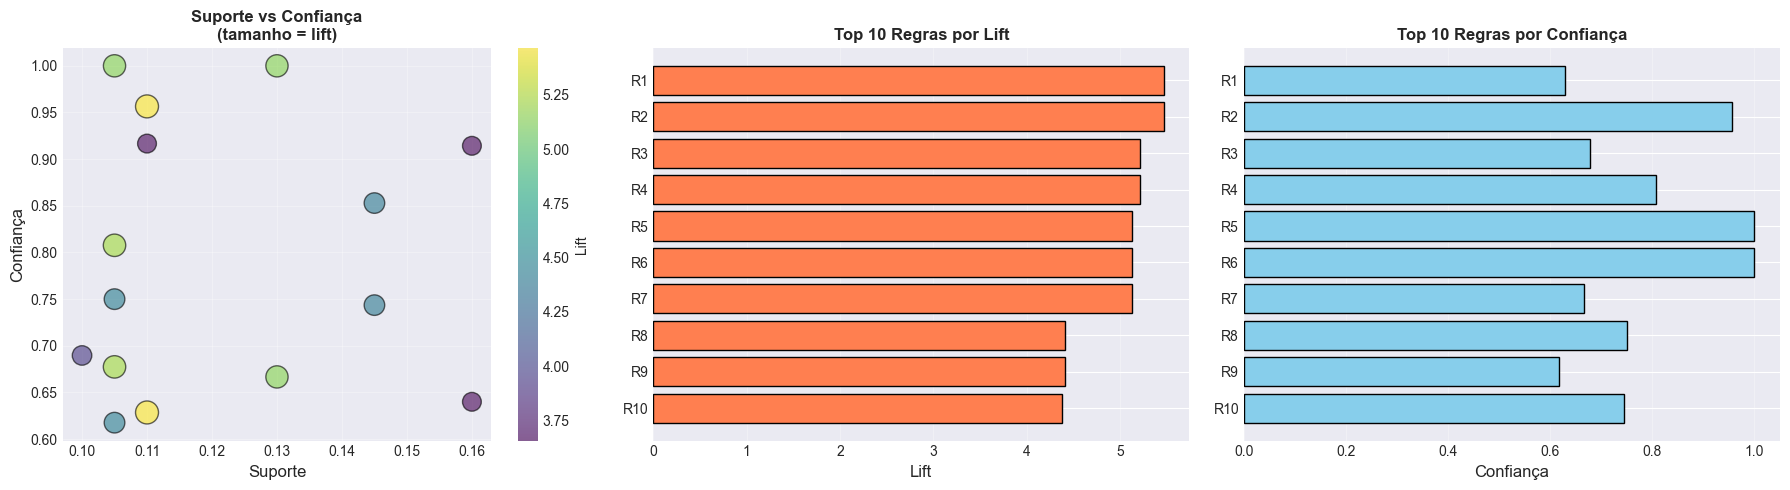


✓ Regras salvas em 'regras_associacao_apriori.csv'


In [41]:
# 6.3 Gerar Regras de Associação
print("\n6.3 Gerando Regras de Associação")
print("Parâmetros: confiança mínima = 0.60 (60%)")

if len(frequent_itemsets) > 0:
    rules = association_rules(
        frequent_itemsets, metric="confidence", min_threshold=0.60
    )

    # Filtrar por lift > 1.0
    rules = rules[rules["lift"] > 1.0]
    rules = rules.sort_values("lift", ascending=False)

    print(f"\nTotal de regras descobertas: {len(rules)}")

    if len(rules) > 0:
        print("\n" + "=" * 80)
        print("TOP 15 REGRAS DE ASSOCIAÇÃO (ordenadas por Lift)")
        print("=" * 80)

        top_rules = rules.head(15)

        for idx, rule in top_rules.iterrows():
            print(f"\n{'─'*80}")
            print(f"Regra {idx + 1}:")
            print(f"  {list(rule['antecedents'])} → {list(rule['consequents'])}")
            print(f"  Suporte: {rule['support']:.3f} ({rule['support']*100:.1f}%)")
            print(
                f"  Confiança: {rule['confidence']:.3f} ({rule['confidence']*100:.1f}%)"
            )
            print(f"  Lift: {rule['lift']:.3f}")

            # Interpretação
            conf_pct = rule["confidence"] * 100
            antecedent_str = ", ".join(list(rule["antecedents"]))
            consequent_str = ", ".join(list(rule["consequents"]))

            print(
                f"  Interpretação: {conf_pct:.1f}% dos clientes com '{antecedent_str}'"
            )
            print(f"                 também possuem '{consequent_str}'.")

            if rule["lift"] > 1.5:
                print(f"                 Associação FORTE (lift = {rule['lift']:.3f})")
            elif rule["lift"] > 1.2:
                print(
                    f"                 Associação MODERADA (lift = {rule['lift']:.3f})"
                )
            else:
                print(f"                 Associação FRACA (lift = {rule['lift']:.3f})")

        # Visualização das regras
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Scatter: Support vs Confidence
        scatter = axes[0].scatter(
            top_rules["support"],
            top_rules["confidence"],
            s=top_rules["lift"] * 50,
            c=top_rules["lift"],
            cmap="viridis",
            alpha=0.6,
            edgecolors="black",
        )
        axes[0].set_xlabel("Suporte", fontsize=12)
        axes[0].set_ylabel("Confiança", fontsize=12)
        axes[0].set_title(
            "Suporte vs Confiança\n(tamanho = lift)", fontsize=12, fontweight="bold"
        )
        axes[0].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0], label="Lift")

        # Top regras por Lift
        top_10_lift = top_rules.head(10)
        rule_names = [f"R{i+1}" for i in range(len(top_10_lift))]
        axes[1].barh(
            rule_names, top_10_lift["lift"].values, color="coral", edgecolor="black"
        )
        axes[1].set_xlabel("Lift", fontsize=12)
        axes[1].set_title("Top 10 Regras por Lift", fontsize=12, fontweight="bold")
        axes[1].grid(True, axis="x", alpha=0.3)
        axes[1].invert_yaxis()

        # Top regras por Confiança
        top_10_conf = top_rules.head(10)
        axes[2].barh(
            rule_names,
            top_10_conf["confidence"].values,
            color="skyblue",
            edgecolor="black",
        )
        axes[2].set_xlabel("Confiança", fontsize=12)
        axes[2].set_title("Top 10 Regras por Confiança", fontsize=12, fontweight="bold")
        axes[2].grid(True, axis="x", alpha=0.3)
        axes[2].invert_yaxis()

        plt.tight_layout()
        plt.show()

        # Salvar regras em CSV
        rules_to_save = top_rules[
            ["antecedents", "consequents", "support", "confidence", "lift"]
        ].copy()
        rules_to_save["antecedents"] = rules_to_save["antecedents"].apply(
            lambda x: ", ".join(list(x))
        )
        rules_to_save["consequents"] = rules_to_save["consequents"].apply(
            lambda x: ", ".join(list(x))
        )
        rules_to_save.to_csv("regras_associacao_apriori.csv", index=False)
        print("\n✓ Regras salvas em 'regras_associacao_apriori.csv'")

#### 7. RESULTADOS E CONCLUSÕES

In [42]:
print("\n📊 RESUMO EXECUTIVO")
print("─" * 80)
print(f"✓ Dataset analisado: {len(df)} clientes")
print(f"✓ Número de clusters identificados: {k_otimo}")
print(f"✓ Qualidade da segmentação (Silhueta): {silhueta:.4f}")


📊 RESUMO EXECUTIVO
────────────────────────────────────────────────────────────────────────────────
✓ Dataset analisado: 200 clientes
✓ Número de clusters identificados: 5
✓ Qualidade da segmentação (Silhueta): 0.5595


In [43]:
if len(rules) > 0:
    print(f"✓ Regras de associação descobertas: {len(rules)} regras")
    print(f"✓ Regra com maior lift: {rules.iloc[0]['lift']:.3f}")

✓ Regras de associação descobertas: 78 regras
✓ Regra com maior lift: 5.466


In [44]:
print("\n🎯 SEGMENTOS IDENTIFICADOS")
print("─" * 80)
for cluster_id in sorted(df_processed["Cluster_KMeans"].unique()):
    cluster_data = df_processed[df_processed["Cluster_KMeans"] == cluster_id]
    avg_income = cluster_data["Annual Income (k$)"].mean()
    avg_score = cluster_data["Spending Score (1-100)"].mean()

    if avg_income < 50 and avg_score < 40:
        perfil = "Econômicos"
        estrategia = "Promoções e ofertas de valor"
    elif avg_income > 70 and avg_score > 60:
        perfil = "Premium"
        estrategia = "Produtos exclusivos e experiência VIP"
    elif avg_income < 50 and avg_score > 60:
        perfil = "Entusiastas"
        estrategia = "Parcelamento e programas de fidelidade"
    elif avg_income > 70 and avg_score < 40:
        perfil = "Conservadores"
        estrategia = "Produtos de qualidade com boa relação custo-benefício"
    else:
        perfil = "Moderados"
        estrategia = "Mix balanceado de produtos e promoções"

    print(f"\nCluster {cluster_id} - {perfil}")
    print(
        f"  • Tamanho: {len(cluster_data)} clientes ({len(cluster_data)/len(df)*100:.1f}%)"
    )
    print(f"  • Renda média: ${avg_income:.1f}k | Score médio: {avg_score:.1f}")
    print(f"  • Estratégia recomendada: {estrategia}")


🎯 SEGMENTOS IDENTIFICADOS
────────────────────────────────────────────────────────────────────────────────

Cluster 0 - Entusiastas
  • Tamanho: 22 clientes (11.0%)
  • Renda média: $25.7k | Score médio: 79.4
  • Estratégia recomendada: Parcelamento e programas de fidelidade

Cluster 1 - Conservadores
  • Tamanho: 35 clientes (17.5%)
  • Renda média: $88.2k | Score médio: 17.1
  • Estratégia recomendada: Produtos de qualidade com boa relação custo-benefício

Cluster 2 - Premium
  • Tamanho: 39 clientes (19.5%)
  • Renda média: $86.5k | Score médio: 82.1
  • Estratégia recomendada: Produtos exclusivos e experiência VIP

Cluster 3 - Moderados
  • Tamanho: 81 clientes (40.5%)
  • Renda média: $55.3k | Score médio: 49.5
  • Estratégia recomendada: Mix balanceado de produtos e promoções

Cluster 4 - Econômicos
  • Tamanho: 23 clientes (11.5%)
  • Renda média: $26.3k | Score médio: 20.9
  • Estratégia recomendada: Promoções e ofertas de valor


In [45]:
print("\n💡 PRINCIPAIS INSIGHTS DO APRIORI")
print("─" * 80)
if len(rules) > 0:
    print("\nPadrões de associação descobertos:")
    for idx, rule in rules.head(5).iterrows():
        antecedent_str = ", ".join(list(rule["antecedents"]))
        consequent_str = ", ".join(list(rule["consequents"]))
        print(f"\n  • {antecedent_str} → {consequent_str}")
        print(
            f"    Confiança: {rule['confidence']*100:.1f}% | Lift: {rule['lift']:.2f}"
        )
else:
    print("\nNenhuma regra de associação foi descoberta com os parâmetros definidos.")


💡 PRINCIPAIS INSIGHTS DO APRIORI
────────────────────────────────────────────────────────────────────────────────

Padrões de associação descobertos:

  • Cluster_1 → Score_Baixo, Renda_Media
    Confiança: 62.9% | Lift: 5.47

  • Score_Baixo, Renda_Media → Cluster_1
    Confiança: 95.7% | Lift: 5.47

  • Adulto, Cluster_2 → Score_Alto, Renda_Media
    Confiança: 67.7% | Lift: 5.21

  • Score_Alto, Renda_Media → Adulto, Cluster_2
    Confiança: 80.8% | Lift: 5.21

  • Score_Alto, Renda_Media → Cluster_2
    Confiança: 100.0% | Lift: 5.13


In [46]:
print("\n4. AÇÕES TÁTICAS POR SEGMENTO")
for cluster_id in sorted(df_processed["Cluster_KMeans"].unique()):
    cluster_data = df_processed[df_processed["Cluster_KMeans"] == cluster_id]
    avg_income = cluster_data["Annual Income (k$)"].mean()
    avg_score = cluster_data["Spending Score (1-100)"].mean()

    if avg_income < 50 and avg_score < 40:
        acoes = [
            "Campanhas de cupons e descontos",
            "Produtos de entrada e promoções",
            "Comunicação focada em valor e economia",
        ]
    elif avg_income > 70 and avg_score > 60:
        acoes = [
            "Lançamentos exclusivos e pré-vendas",
            "Atendimento VIP e experiências premium",
            "Programa de fidelidade com benefícios exclusivos",
        ]
    elif avg_income < 50 and avg_score > 60:
        acoes = [
            "Opções de parcelamento facilitado",
            "Programa de pontos e cashback",
            "Promoções frequentes e limitadas",
        ]
    elif avg_income > 70 and avg_score < 40:
        acoes = [
            "Produtos de qualidade premium",
            "Garantias estendidas e serviços pós-venda",
            "Comunicação sobre durabilidade e valor",
        ]
    else:
        acoes = [
            "Mix balanceado de produtos e preços",
            "Promoções sazonais",
            "Cross-selling baseado em padrões",
        ]

    print(f"\n  Cluster {cluster_id}:")
    for acao in acoes:
        print(f"    • {acao}")


4. AÇÕES TÁTICAS POR SEGMENTO

  Cluster 0:
    • Opções de parcelamento facilitado
    • Programa de pontos e cashback
    • Promoções frequentes e limitadas

  Cluster 1:
    • Produtos de qualidade premium
    • Garantias estendidas e serviços pós-venda
    • Comunicação sobre durabilidade e valor

  Cluster 2:
    • Lançamentos exclusivos e pré-vendas
    • Atendimento VIP e experiências premium
    • Programa de fidelidade com benefícios exclusivos

  Cluster 3:
    • Mix balanceado de produtos e preços
    • Promoções sazonais
    • Cross-selling baseado em padrões

  Cluster 4:
    • Campanhas de cupons e descontos
    • Produtos de entrada e promoções
    • Comunicação focada em valor e economia


#### 8. EXPORTAR RESULTADOS

In [47]:
# Salvar dataset com clusters
df_final = df_processed[
    [
        "CustomerID",
        "Gender",
        "Age",
        "Annual Income (k$)",
        "Spending Score (1-100)",
        "Idade_Group",
        "Renda_Group",
        "Score_Group",
        "Cluster_KMeans",
        "Cluster_Hierarchical",
    ]
]
df_final.to_csv("clientes_segmentados.csv", index=False)
print("✓ Dataset com clusters salvo em 'clientes_segmentados.csv'")

✓ Dataset com clusters salvo em 'clientes_segmentados.csv'


In [48]:
# Salvar perfil dos clusters
perfis_clusters = []
for cluster_id in sorted(df_processed["Cluster_KMeans"].unique()):
    cluster_data = df_processed[df_processed["Cluster_KMeans"] == cluster_id]
    perfis_clusters.append(
        {
            "Cluster": cluster_id,
            "QuantAge": len(cluster_data),
            "Percentual": f"{len(cluster_data)/len(df)*100:.1f}%",
            "Age_Media": f"{cluster_data['Age'].mean():.1f}",
            "Renda_Media": f"{cluster_data['Annual Income (k$)'].mean():.1f}",
            "Score_Medio": f"{cluster_data['Spending Score (1-100)'].mean():.1f}",
            "Perc_Masculino": f"{(cluster_data['Gender'] == 'Male').sum() / len(cluster_data) * 100:.1f}%",
        }
    )

df_perfis = pd.DataFrame(perfis_clusters)
df_perfis.to_csv("perfil_clusters.csv", index=False)
print("✓ Perfil dos clusters salvo em 'perfil_clusters.csv'")

✓ Perfil dos clusters salvo em 'perfil_clusters.csv'


In [49]:
# Salvar métricas
metricas_resumo = {
    "Metrica": [
        "Total_Clientes",
        "Numero_Clusters",
        "Silhueta_KMeans",
        "Silhueta_Hierarchical",
        "Davies_Bouldin",
        "Inercia",
        "Total_Regras_Apriori",
    ],
    "Valor": [
        len(df),
        k_otimo,
        f"{silhueta:.4f}",
        f"{silhueta_hier:.4f}",
        f"{davies_bouldin:.4f}",
        f"{kmeans_final.inertia_:.4f}",
        len(rules) if len(rules) > 0 else 0,
    ],
}
df_metricas = pd.DataFrame(metricas_resumo)
df_metricas.to_csv("metricas_projeto.csv", index=False)
print("✓ Métricas do projeto salvas em 'metricas_projeto.csv'")

✓ Métricas do projeto salvas em 'metricas_projeto.csv'


Este projeto demonstrou a eficácia de técnicas de mineração de dados para segmentação de clientes e descoberta de padrões comportamentais. A metodologia aplicada permitiu:

✓ Identificar grupos distintos de clientes com características homogêneas

✓ Descobrir regras de associação entre atributos demográficos e comportamentais

✓ Gerar insights acionáveis para estratégias de marketing data-driven

Os resultados obtidos podem ser diretamente aplicados para:
- Personalização de campanhas de marketing
- Otimização de recursos e orçamento
- Melhoria da experiência do cliente
- Aumento de conversão e ticket médio

A combinação de K-means para segmentação e Apriori para descoberta de padrõ esse mostrou eficaz, possibilitando uma visão abrangente do comportamento dos clientes e fornecendo base sólida para tomada de decisão estratégica.


## RECOMENDAÇÕES ESTRATÉGICAS


### 1. MARKETING PERSONALIZADO
- Criar campanhas específicas para cada segmento
- Utilizar regras de associação para cross-selling
- Desenvolver comunicação direcionada por perfil

### 2. OTIMIZAÇÃO DE RECURSOS
- Alocar orçamento baseado no potencial de cada cluster
- Priorizar segmentos de alto valor (alta renda + alto gasto)
- Ajustar mix de produtos para cada perfil

### 3. EXPERIÊNCIA DO CLIENTE
- Personalizar jornada de compra por segmento
- Implementar sistema de recomendação baseado em regras
- Criar programas de fidelidade customizados